# Với từng ảnh: 

Trực quan hóa từng kết quả layer sau khi cho 1 ảnh input qua các lớp trong mạng học sâu 

Trực quan các nhãn kết quả dự đoán với mỗi ảnh

# Trực quan hóa từng kết quả layer sau khi cho 1 ảnh input qua các lớp trong mạng học sâu 

In [2]:
%cd /Data/Projects/ThyroidCancerClassifier

/Data/Projects/ThyroidCancerClassifier


In [5]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from src.model.classifier.H97 import H97_EfficientNet

# Tạo mô hình
model_path = "/Data/Projects/ThyroidCancer_InfoData_Local/kaggle/working/h97_retrainEfficientNet_B2_B5_B6_dataver3/best_h97_retrainEfficientNet_B2_B5_B6_dataver3_model.pt"
model = H97_EfficientNet()
model.load_state_dict(
    torch.load(
        model_path,
        map_location=torch.device("cpu"),
    )
)

<All keys matched successfully>

In [12]:
# Load ảnh và tiền xử lý
def load_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Thay đổi kích thước ảnh về 224x224
        transforms.ToTensor(),  # Chuyển ảnh thành tensor
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Chuẩn hóa ảnh
    ])
    image = Image.open(image_path)
    image = transform(image)
    image = image.unsqueeze(0)  # Thêm batch dimension
    return image

# Hook lưu các đầu ra trung gian
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Đăng ký hook cho feature extractor
for name, layer in model.feature_extractor.named_children():
    print(f'Name of layer: {name}, Layer: {layer}')
    layer.register_forward_hook(get_activation(name))

# Chạy mô hình với ảnh đầu vào
image_path = '/Data/Projects/ThyroidCancer_InfoData_Local/dataver3/train/B5/431_3.jpg'
input_image = load_image(image_path)
model.eval()
with torch.no_grad():
    output = model(input_image)

Name of layer: 0, Layer: Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_siz

In [25]:
input_image

tensor([[[[0.8353, 0.8196, 0.8039,  ..., 0.8824, 0.8941, 0.9020],
          [0.8275, 0.8078, 0.7922,  ..., 0.8863, 0.8941, 0.9020],
          [0.8157, 0.7961, 0.7843,  ..., 0.8745, 0.8824, 0.8902],
          ...,
          [0.9725, 0.9804, 0.9882,  ..., 0.1098, 0.1294, 0.1294],
          [0.9922, 0.9961, 0.9961,  ..., 0.1020, 0.1176, 0.1294],
          [1.0000, 1.0000, 1.0000,  ..., 0.0902, 0.1059, 0.1294]],

         [[0.7176, 0.7059, 0.6902,  ..., 0.8118, 0.8118, 0.8118],
          [0.7098, 0.6980, 0.6824,  ..., 0.8196, 0.8157, 0.8157],
          [0.7059, 0.6941, 0.6784,  ..., 0.8078, 0.8078, 0.8118],
          ...,
          [0.8824, 0.8863, 0.8902,  ..., 0.0980, 0.1137, 0.1059],
          [0.9020, 0.9059, 0.9020,  ..., 0.0863, 0.1020, 0.1059],
          [0.9137, 0.9176, 0.9137,  ..., 0.0745, 0.0902, 0.1059]],

         [[0.9608, 0.9569, 0.9529,  ..., 1.0000, 0.9922, 0.9922],
          [0.9647, 0.9569, 0.9569,  ..., 1.0000, 1.0000, 0.9961],
          [0.9725, 0.9647, 0.9608,  ..., 1

Trực hóa hóa lớp 0
Kích thước của tensor: torch.Size([1, 1280, 7, 7])


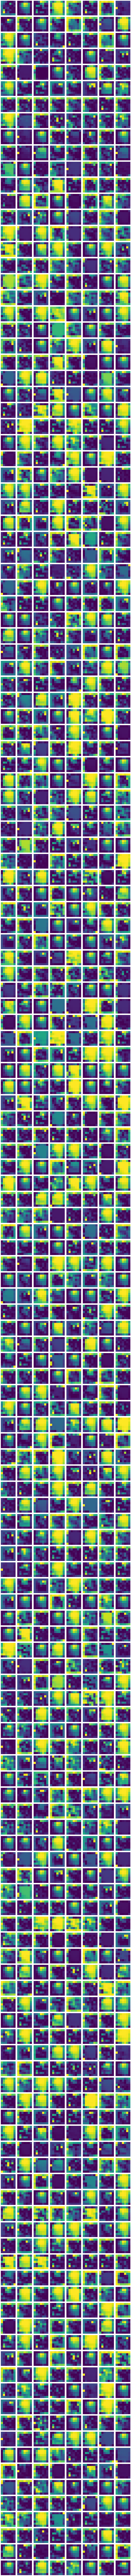

Trực hóa hóa lớp 1
Kích thước của tensor: torch.Size([1, 1280, 1, 1])


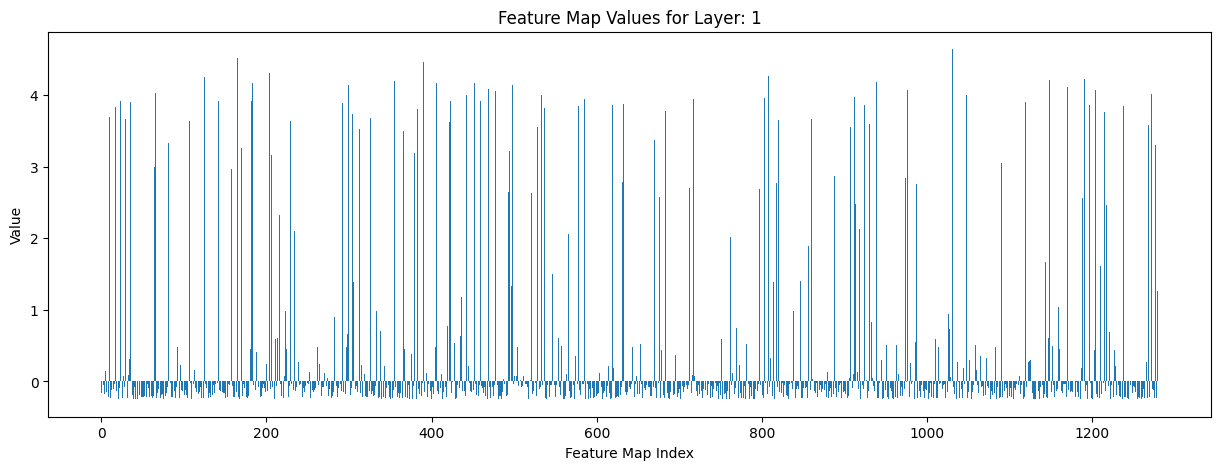

In [24]:
# Trực quan hóa các đầu ra trung gian
def plot_activation(activation, layer_name):
    print(f"Trực hóa hóa lớp {layer_name}")
    print(f"Kích thước của tensor: {activation[layer_name].shape}")
    act = activation[layer_name].squeeze()  # Loại bỏ batch dimension
    num_feature_maps = act.size(0)

    if len(act.size()) == 1:  # Tensor có kích thước [1280]
        # Hiển thị các giá trị của các feature maps dưới dạng biểu đồ
        plt.figure(figsize=(15, 5))
        plt.bar(np.arange(num_feature_maps), act.cpu().numpy())
        plt.xlabel('Feature Map Index')
        plt.ylabel('Value')
        plt.title(f'Feature Map Values for Layer: {layer_name}')
        plt.show()
    elif len(act.size()) == 3:  # Tensor có kích thước [1280, 7, 7]
        num_cols = 8
        num_rows = (num_feature_maps + num_cols - 1) // num_cols
        figsize = (num_cols * 2.5, num_rows * 2.5)  # Điều chỉnh kích thước hình ảnh
        fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
        axes = axes.flatten()
        for i in range(num_feature_maps):
            axes[i].imshow(act[i].cpu().numpy(), cmap='viridis')
            axes[i].axis('off')
        for i in range(num_feature_maps, len(axes)):
            axes[i].axis('off')

        plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Điều chỉnh khoảng cách giữa các cột và hàng
        plt.show()
    else:
        print(f"Không thể trực quan hóa tensor với hình dạng {act.shape} | act size: {act.size()}")

# Trực quan hóa đầu ra của lớp 0
for name in activation:
    plot_activation(activation, name)

# Way to run YOLO model with ONNX

In [ ]:
import onnxruntime as ort
import numpy as np
import cv2

# Load ONNX model
onnx_model_path = 'path/to/your/model.onnx'
session = ort.InferenceSession(onnx_model_path)

# Get model input and output names
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

# Load and preprocess input image
def preprocess(image_path, target_size=(640, 480)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)  # Resize to the target size
    image = image.astype(np.float32)
    image = image / 255.0  # Normalize to [0, 1]
    image = np.transpose(image, (2, 0, 1))  # Change data layout from HWC to CHW
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Perform inference
image_path = 'path/to/your/image.jpg'
input_image = preprocess(image_path, target_size=(640, 480))  # Change to (1024, 768) if needed
results = session.run([output_name], {input_name: input_image})

# Process the results
# Assuming the model outputs bounding boxes in the format (batch, boxes, 4) and class probabilities (batch, boxes, num_classes)
boxes = results[0][0]  # Get the bounding boxes
scores = results[1][0]  # Get the class probabilities

# Example: Print the results
print("Bounding Boxes:", boxes)
print("Scores:", scores)
